# Consolidation test - poroelasticity

### Install dependencies

Bring fenicsx to the environement.
It takes 1-2 minutes to run.

In [2]:
try:
    import google.colab  # noqa: F401
except ImportError:
    import ufl
    import dolfinx
else:
    !wget "https://fem-on-colab.github.io/releases/fenicsx-install-release-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import ufl
    import dolfinx

try:
    import gmsh
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
    import gmsh

--2026-02-13 22:30:41--  https://fem-on-colab.github.io/releases/fenicsx-install-release-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4339 (4.2K) [application/x-sh]
Saving to: ‘/tmp/fenicsx-install.sh’

/tmp/fenicsx-instal 100%[===================>]   4.24K  --.-KB/s    in 0s      

2026-02-13 22:30:42 (41.9 MB/s) - ‘/tmp/fenicsx-install.sh’ saved [4339/4339]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICSX_INSTALLED=/usr/local/share/fem-on-colab/fenicsx.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenicsx.installed ]]
+ set +x
























#########################################################################

### Import all dependencies

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import ipywidgets as widgets
from IPython.display import display

from mpi4py import MPI
from dolfinx import mesh, fem
import ufl
from basix.ufl import element

from dolfinx.fem.petsc import LinearProblem

### Build mesh

We are using a simple generator from fenicsx environment.
For nicer meshes, I suggest using gmsh.

In [74]:
import gmsh
import numpy as np
from mpi4py import MPI
from dolfinx.io import gmsh as gmshio

# Boundary tags
LEFT, RIGHT, BOTTOM, TOP, FRAC = 1, 2, 3, 4, 5

# Geometry parameters
L = 1.0  # Width
H = 1.0  # Height
half_frac = 0.1  # Half-length of fracture segment
lc = 0.05  # Characteristic length (mesh size)
lc_frac = lc / 10  # Refined mesh size near fracture endpoints

# Initialize gmsh
gmsh.initialize()
gmsh.model.add("square_with_frac")

# Create corner points
p1 = gmsh.model.geo.addPoint(0, 0, 0, lc)  # Bottom-left
p2 = gmsh.model.geo.addPoint(L, 0, 0, lc)  # Bottom-right
p3 = gmsh.model.geo.addPoint(L, H, 0, lc)  # Top-right
p4 = gmsh.model.geo.addPoint(0, H, 0, lc)  # Top-left

# Create points on left boundary for fracture segment
p_frac_bottom = gmsh.model.geo.addPoint(0, H/2 - half_frac, 0, lc_frac)
p_frac_top = gmsh.model.geo.addPoint(0, H/2 + half_frac, 0, lc_frac)

# Create lines
# Left boundary (split into 3 parts)
left_top = gmsh.model.geo.addLine(p4, p_frac_top)  # Top to frac end
frac_line = gmsh.model.geo.addLine(p_frac_top, p_frac_bottom)  # Fracture segment
left_bottom = gmsh.model.geo.addLine(p_frac_bottom, p1)  # Frac start to bottom

# Other boundaries
bottom = gmsh.model.geo.addLine(p1, p2)
right = gmsh.model.geo.addLine(p2, p3)
top = gmsh.model.geo.addLine(p3, p4)

# Create curve loop and surface
curve_loop = gmsh.model.geo.addCurveLoop([bottom, right, top, left_top, frac_line, left_bottom])
surface = gmsh.model.geo.addPlaneSurface([curve_loop])

# Synchronize to finalize geometry
gmsh.model.geo.synchronize()

# Add physical groups for boundaries
gmsh.model.addPhysicalGroup(1, [left_bottom, left_top], LEFT, "Left")
gmsh.model.addPhysicalGroup(1, [right], RIGHT, "Right")
gmsh.model.addPhysicalGroup(1, [bottom], BOTTOM, "Bottom")
gmsh.model.addPhysicalGroup(1, [top], TOP, "Top")
gmsh.model.addPhysicalGroup(1, [frac_line], FRAC, "Fracture")

# Add physical group for the domain (required for FEniCSx)
gmsh.model.addPhysicalGroup(2, [surface], 1, "Domain")

# --- Add sizing field for refinement near fracture endpoints ---
# Distance field from fracture endpoints
distance_field = gmsh.model.mesh.field.add("Distance")
gmsh.model.mesh.field.setNumbers(distance_field, "PointsList", [p_frac_bottom, p_frac_top])

# Threshold field: gradual transition from fine to coarse
threshold_field = gmsh.model.mesh.field.add("Threshold")
gmsh.model.mesh.field.setNumber(threshold_field, "InField", distance_field)
gmsh.model.mesh.field.setNumber(threshold_field, "SizeMin", lc_frac)  # Fine mesh near fracture
gmsh.model.mesh.field.setNumber(threshold_field, "SizeMax", lc)       # Coarse mesh far away
gmsh.model.mesh.field.setNumber(threshold_field, "DistMin", 0.05)     # Start transition at 0.05 from points
gmsh.model.mesh.field.setNumber(threshold_field, "DistMax", 0.2)      # End transition at 0.2 from points

# Set as background mesh
gmsh.model.mesh.field.setAsBackgroundMesh(threshold_field)

# Optional: Use algorithm that respects background mesh
gmsh.option.setNumber("Mesh.MeshSizeExtendFromBoundary", 0)
gmsh.option.setNumber("Mesh.MeshSizeFromPoints", 0)
gmsh.option.setNumber("Mesh.MeshSizeFromCurvature", 0)

# Generate 2D mesh
gmsh.model.mesh.generate(2)

# Optional: Write mesh file for visualization
# gmsh.write("mesh_refined.msh")

# Convert to dolfinx mesh using the specified pattern
mesh_data = gmshio.model_to_mesh(
    gmsh.model,
    MPI.COMM_WORLD,
    0,  # MPI rank
    gdim=2  # Geometric dimension
)
domain = mesh_data.mesh
facets = mesh_data.facet_tags

gmsh.finalize()

print(f"Mesh created with {domain.topology.index_map(2).size_local} cells")
print(f"Refinement: {lc_frac:.4f} m near fracture tips, {lc:.4f} m elsewhere")

Mesh created with 2366 cells
Refinement: 0.0050 m near fracture tips, 0.0500 m elsewhere


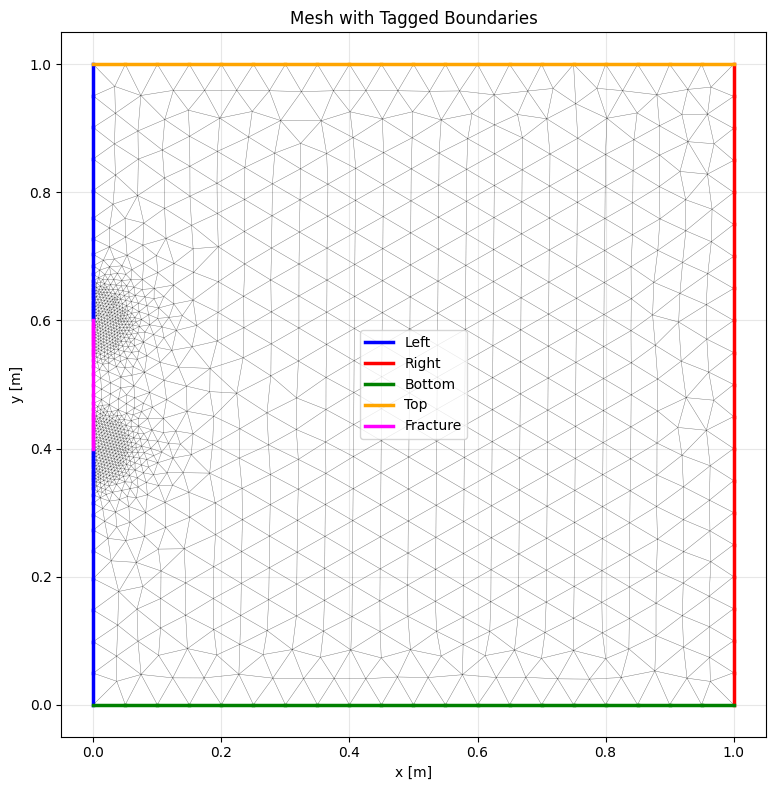

In [75]:
#
# PLOT THE MESH
#

# Extract mesh data
points = domain.geometry.x[:, :2]
cells = domain.topology.connectivity(domain.topology.dim, 0).array.reshape((-1, 3))
domain.topology.create_connectivity(domain.topology.dim - 1, 0)
facet_to_vertex = domain.topology.connectivity(domain.topology.dim - 1, 0)

# Plot setup
fig, ax = plt.subplots(figsize=(8, 8))

# Plot mesh (light gray)
for cell in cells:
    triangle = np.vstack([points[cell], points[cell[0]]])
    ax.plot(triangle[:, 0], triangle[:, 1], 'k-', linewidth=0.3, alpha=0.3)

# Plot tagged boundaries
tags = {
    LEFT: ['Left', 'blue'],
    RIGHT: ['Right', 'red'],
    BOTTOM: ['Bottom', 'green'],
    TOP: ['Top', 'orange'],
    FRAC: ['Fracture', 'magenta']
}

for tag, (name, color) in tags.items():
    for i, facet_idx in enumerate(facets.find(tag)):
        vertices = facet_to_vertex.links(facet_idx)
        ax.plot(points[vertices, 0], points[vertices, 1], c=color,
                linewidth=2.5, label=name if i == 0 else "")

ax.legend(loc='center')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Mesh with Tagged Boundaries')
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Function spaces

In [ ]:
cell_name = domain.topology.cell_name()
P2 = element("Lagrange", cell_name, 2, shape=(domain.geometry.dim,))
V = fem.functionspace(domain, P2)

# Create integration measure
ds = ufl.Measure("ds", domain=domain, subdomain_data=facets)


### Material properties and constitutive equations

In [77]:
# ------------------ Material parameters ------------------
E = 1e9           # Pa
nu = 0.3

lmbda = E*nu / ((1+nu)*(1-2*nu))
mu = E/(2*(1+nu))

def eps(u):
    return ufl.sym(ufl.grad(u))
def eps_v(u):
    return ufl.tr(eps(u))
def sigma_eff(u):
    return lmbda*ufl.tr(eps(u))*ufl.Identity(2) + 2*mu*eps(u)

# ------------------ Weak form ------------------
def weak_form():
    u  = ufl.TrialFunction(V)
    v  = ufl.TestFunction(V)
    dx = ufl.dx(domain)

    a = ( ufl.inner(sigma_eff(u), eps(v))*dx  )

    # BOUNDARY CONSTRAINT! SIG_H AT THE FRAC
    L = ( fem.Constant(domain, 1.0e6)*v[0]*ds(FRAC) )

    return a, L

### Boundary conditions

In [78]:
# ------------------ Dirichlet BCs ------------------
UX, _ = V.sub(0).collapse()
UY, _ = V.sub(1).collapse()

zero_u = fem.Function(UX)
zero_v = fem.Function(UY)

bcs_data = [
    (LEFT, UX, zero_u, V.sub(0)),
    (RIGHT, UX, zero_u, V.sub(0)),
    (BOTTOM, UY, zero_v, V.sub(1)),
]

fdim = 1 # dimension of the boundaries
bcs = []
for tag, space, value, parent in bcs_data:
    _fac = facets.find(tag)
    dofs = fem.locate_dofs_topological((parent, space), fdim, _fac)
    bcs.append(fem.dirichletbc(value, dofs, parent))

#### Solve

In [ ]:
a, L = weak_form()
problem = LinearProblem(
      a, L,
      bcs=bcs,
      petsc_options={"ksp_type":"preonly", "pc_type":"lu"},
      petsc_options_prefix="test"
  )
uh = problem.solve()
uh.name = "displacement"

### Post processing
Create stress tensor and invariants from displacements

In [80]:
# Post-process: Compute stress tensor and invariants
# Define function spaces with DG1 (linear discontinuous)
T = fem.functionspace(domain, ("DG", 1, (2, 2)))  # Tensor space
S = fem.functionspace(domain, ("DG", 1))          # Scalar space

# Compute stress tensor from displacement
sigma_expr = sigma_eff(uh)
stress_tensor = fem.Function(T, name="Stress")
stress_expr = fem.Expression(sigma_expr, T.element.interpolation_points)
stress_tensor.interpolate(stress_expr)

# Compute P invariant (mean stress / hydrostatic pressure)
# P = -trace(σ)/3 = -(σ_xx + σ_yy)/3
P_expr = -ufl.tr(sigma_expr) / 3
P_invariant = fem.Function(S, name="P_invariant")
P_inv_expr = fem.Expression(P_expr, S.element.interpolation_points)
P_invariant.interpolate(P_inv_expr)

# Compute Q invariant (von Mises equivalent stress)
# Q = sqrt(3/2 * dev(σ):dev(σ))
dev_sigma = sigma_expr - (ufl.tr(sigma_expr) / 3) * ufl.Identity(2)
Q_expr = ufl.sqrt(3.0/2.0 * ufl.inner(dev_sigma, dev_sigma))
Q_invariant = fem.Function(S, name="Q_invariant")
Q_inv_expr = fem.Expression(Q_expr, S.element.interpolation_points)
Q_invariant.interpolate(Q_inv_expr)

print(f"Stress range: [{stress_tensor.x.array.min():.2e}, {stress_tensor.x.array.max():.2e}]")
print(f"P invariant range: [{P_invariant.x.array.min():.2e}, {P_invariant.x.array.max():.2e}]")
print(f"Q invariant range: [{Q_invariant.x.array.min():.2e}, {Q_invariant.x.array.max():.2e}]")

Stress range: [-3.88e+06, 9.51e+06]
P invariant range: [-3.93e+06, 2.08e+06]
Q invariant range: [5.44e+02, 7.31e+06]


### Export to VTX
You can open in Paraview (https://www.paraview.org/)

In [ ]:
# Extract stress components in a loop
stress_components = []
component_names = [("sigma_xx", 0, 0), ("sigma_xy", 0, 1), ("sigma_yy", 1, 1)]
for name, i, j in component_names:
    sigma_comp = fem.Function(S_export, name=name)
    sigma_expr = fem.Expression(stress_tensor[i, j], S_export.element.interpolation_points)
    sigma_comp.interpolate(sigma_expr)
    stress_components.append(sigma_comp)

# Export VTX to open in paraview
from dolfinx.io import VTXWriter
with VTXWriter(domain.comm, "displacement.bp", [uh], engine="BP4") as vtx:
    vtx.write(0.0)
# Export all stress fields with proper component names
with VTXWriter(domain.comm, "stress_fields.bp", 
               stress_components + [P_invariant, Q_invariant], 
               engine="BP4") as vtx:
    vtx.write(0.0)

### Plot the results

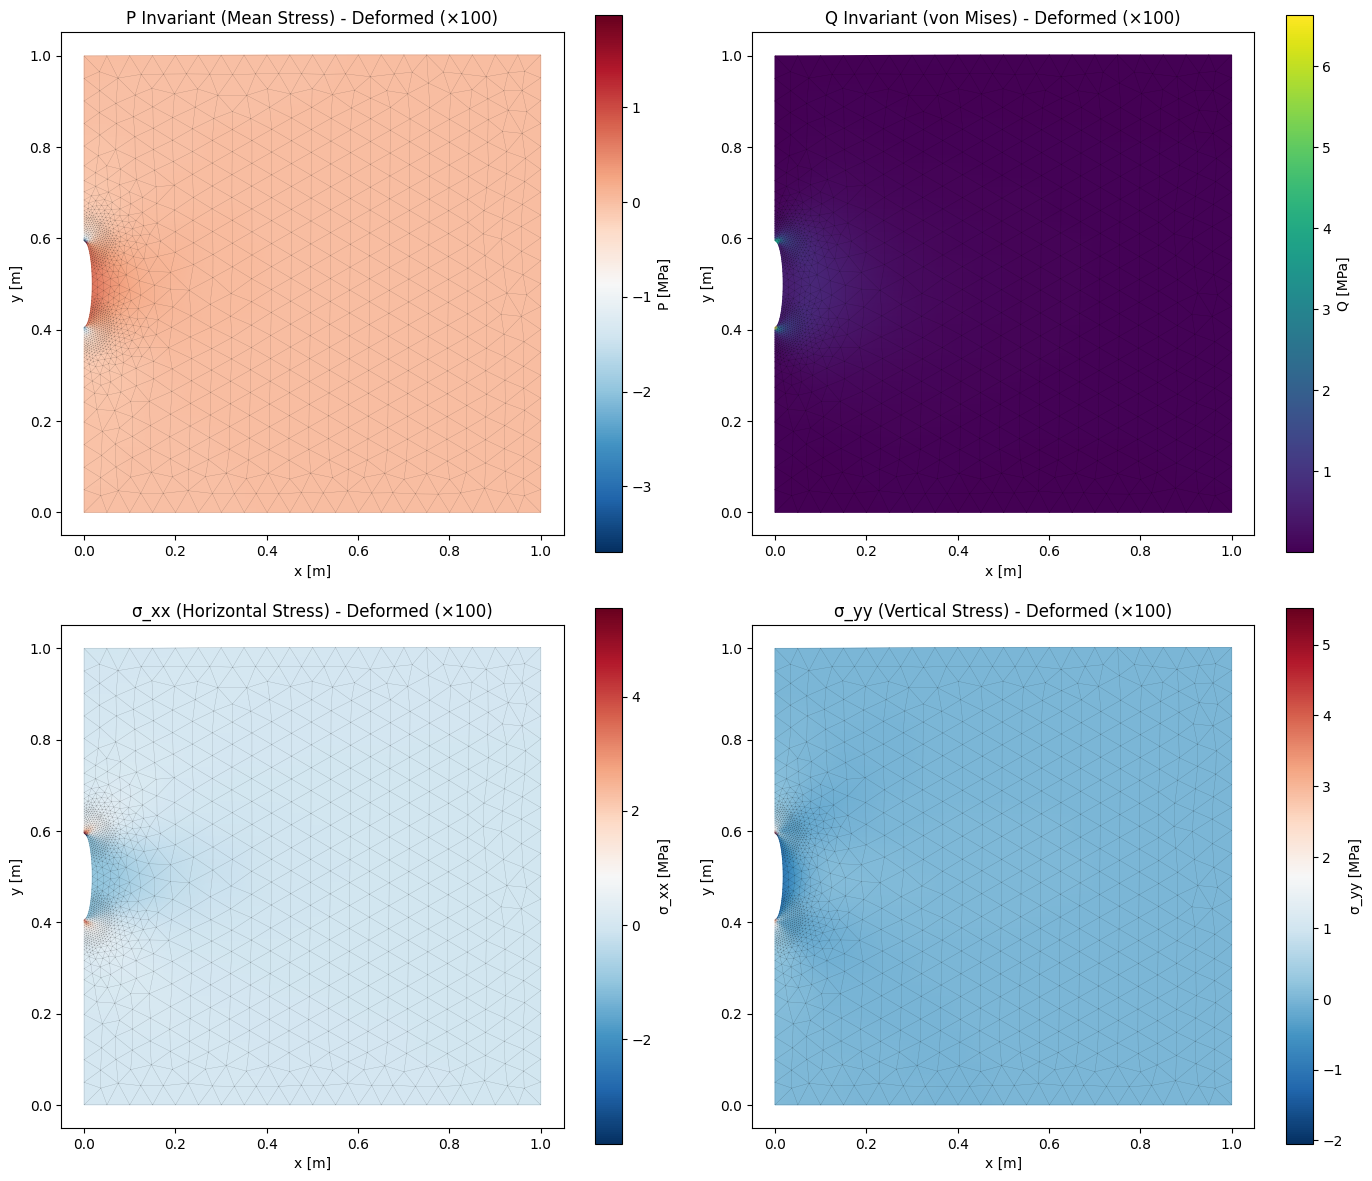

P:     min=-3.69 MPa, max=1.97 MPa
Q:     min=0.00 MPa, max=6.63 MPa
σ_xx:  min=-3.84 MPa, max=5.55 MPa
σ_yy:  min=-2.06 MPa, max=5.52 MPa


In [84]:
# Plot P, Q, sig_xx, sig_yy in 2x2 grid on DEFORMED mesh
import matplotlib.pyplot as plt
import matplotlib.tri as tri

# Extract mesh data
points = domain.geometry.x[:, :2]
cells = domain.topology.connectivity(domain.topology.dim, 0).array.reshape((-1, 3))

# Evaluate displacement at mesh vertices
V_viz_disp = fem.functionspace(domain, ("CG", 1, (2,)))
uh_viz = fem.Function(V_viz_disp)
uh_viz.interpolate(uh)
u_values = uh_viz.x.array.reshape((-1, 2))

# Create deformed coordinates with magnification
magnification = 100
deformed_points = points + magnification * u_values

# Create triangulation with DEFORMED mesh
triangulation_deformed = tri.Triangulation(deformed_points[:, 0], deformed_points[:, 1], cells)

# For DG1, we need to evaluate at vertices for smooth plotting
# Create CG1 functions for visualization
V_viz_scalar = fem.functionspace(domain, ("CG", 1))
V_viz_tensor = fem.functionspace(domain, ("CG", 1, (2, 2)))

# Interpolate to CG1 for smooth visualization
P_viz = fem.Function(V_viz_scalar)
P_viz.interpolate(fem.Expression(P_invariant, V_viz_scalar.element.interpolation_points))

Q_viz = fem.Function(V_viz_scalar)
Q_viz.interpolate(fem.Expression(Q_invariant, V_viz_scalar.element.interpolation_points))

stress_viz = fem.Function(V_viz_tensor)
stress_viz.interpolate(fem.Expression(stress_tensor, V_viz_tensor.element.interpolation_points))

# Convert to MPa
P_MPa = P_viz.x.array / 1e6
Q_MPa = Q_viz.x.array / 1e6
stress_array = stress_viz.x.array.reshape((-1, 2, 2))
sig_xx_MPa = stress_array[:, 0, 0] / 1e6
sig_yy_MPa = stress_array[:, 1, 1] / 1e6

# Create 2x2 figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 12))

# Plot P invariant on deformed mesh
tpc1 = ax1.tripcolor(triangulation_deformed, P_MPa, shading='gouraud', cmap='RdBu_r')
ax1.set_xlabel('x [m]')
ax1.set_ylabel('y [m]')
ax1.set_title(f'P Invariant (Mean Stress) - Deformed (×{magnification})')
ax1.set_aspect('equal')
cbar1 = plt.colorbar(tpc1, ax=ax1)
cbar1.set_label('P [MPa]')

# Plot Q invariant on deformed mesh
tpc2 = ax2.tripcolor(triangulation_deformed, Q_MPa, shading='gouraud', cmap='viridis')
ax2.set_xlabel('x [m]')
ax2.set_ylabel('y [m]')
ax2.set_title(f'Q Invariant (von Mises) - Deformed (×{magnification})')
ax2.set_aspect('equal')
cbar2 = plt.colorbar(tpc2, ax=ax2)
cbar2.set_label('Q [MPa]')

# Plot sig_xx on deformed mesh
tpc3 = ax3.tripcolor(triangulation_deformed, sig_xx_MPa, shading='gouraud', cmap='RdBu_r')
ax3.set_xlabel('x [m]')
ax3.set_ylabel('y [m]')
ax3.set_title(f'σ_xx (Horizontal Stress) - Deformed (×{magnification})')
ax3.set_aspect('equal')
cbar3 = plt.colorbar(tpc3, ax=ax3)
cbar3.set_label('σ_xx [MPa]')

# Plot sig_yy on deformed mesh
tpc4 = ax4.tripcolor(triangulation_deformed, sig_yy_MPa, shading='gouraud', cmap='RdBu_r')
ax4.set_xlabel('x [m]')
ax4.set_ylabel('y [m]')
ax4.set_title(f'σ_yy (Vertical Stress) - Deformed (×{magnification})')
ax4.set_aspect('equal')
cbar4 = plt.colorbar(tpc4, ax=ax4)
cbar4.set_label('σ_yy [MPa]')

# Add mesh edges on deformed configuration
for ax in [ax1, ax2, ax3, ax4]:
    ax.triplot(triangulation_deformed, 'k-', linewidth=0.2, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"P:     min={P_MPa.min():.2f} MPa, max={P_MPa.max():.2f} MPa")
print(f"Q:     min={Q_MPa.min():.2f} MPa, max={Q_MPa.max():.2f} MPa")
print(f"σ_xx:  min={sig_xx_MPa.min():.2f} MPa, max={sig_xx_MPa.max():.2f} MPa")
print(f"σ_yy:  min={sig_yy_MPa.min():.2f} MPa, max={sig_yy_MPa.max():.2f} MPa")

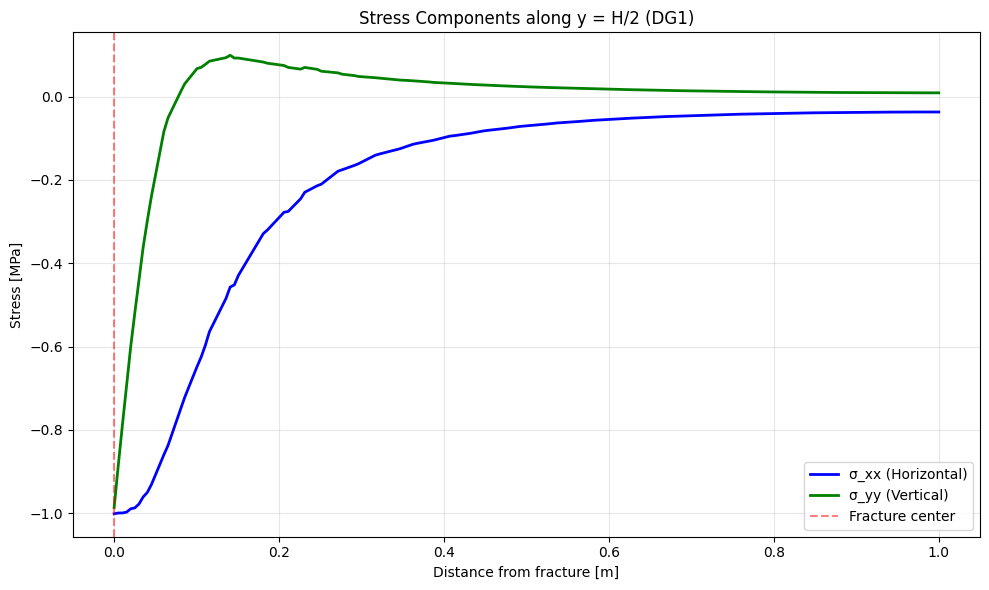

Line evaluation points: 200
σ_xx range: [-1.00, -0.04] MPa
σ_yy range: [-0.99, 0.10] MPa


In [99]:
# Plot sig_xx and sig_yy along horizontal line - extract from tensor
import matplotlib.pyplot as plt
import numpy as np

# Geometry parameters
L_geom = 1.0
H_geom = 1.0

# Define horizontal line: y = H/2, x from 0 to L
num_points = 200
x_line = np.linspace(0, L_geom, num_points)
y_line = np.full_like(x_line, H_geom/2)
z_line = np.zeros_like(x_line)
points_line = np.column_stack([x_line, y_line, z_line])

# We already have stress_tensor (DG1 tensor), now create scalar functions for components
S_DG1 = fem.functionspace(domain, ("DG", 1))

# Extract sig_xx component from stress tensor
sig_xx_func = fem.Function(S_DG1, name="sig_xx")
sig_xx_expr = fem.Expression(stress_tensor[0, 0], S_DG1.element.interpolation_points)
sig_xx_func.interpolate(sig_xx_expr)

# Extract sig_yy component from stress tensor
sig_yy_func = fem.Function(S_DG1, name="sig_yy")
sig_yy_expr = fem.Expression(stress_tensor[1, 1], S_DG1.element.interpolation_points)
sig_yy_func.interpolate(sig_yy_expr)

# Use dolfinx's built-in evaluation
from dolfinx import geometry

# Create bounding box tree
bb_tree = geometry.bb_tree(domain, domain.topology.dim)

# Find cells containing the points
cells = []
points_on_proc = []
for point in points_line:
    cell_candidates = geometry.compute_collisions_points(bb_tree, point)
    colliding_cells = geometry.compute_colliding_cells(domain, cell_candidates, point)
    if colliding_cells.array.size > 0:
        cells.append(colliding_cells.array[0])
        points_on_proc.append(point)

points_on_proc = np.array(points_on_proc)

# Evaluate functions at points
if len(points_on_proc) > 0:
    sig_xx_vals = sig_xx_func.eval(points_on_proc, cells) / 1e6
    sig_yy_vals = sig_yy_func.eval(points_on_proc, cells) / 1e6
    x_vals = points_on_proc[:, 0]
else:
    sig_xx_vals = np.array([])
    sig_yy_vals = np.array([])
    x_vals = np.array([])

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(x_vals, sig_xx_vals, 'b-', linewidth=2, label='σ_xx (Horizontal)')
ax.plot(x_vals, sig_yy_vals, 'g-', linewidth=2, label='σ_yy (Vertical)')
ax.axvline(x=0, color='r', linestyle='--', alpha=0.5, label='Fracture center')

ax.set_xlabel('Distance from fracture [m]')
ax.set_ylabel('Stress [MPa]')
ax.set_title('Stress Components along y = H/2 (DG1)')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

print(f"Line evaluation points: {len(x_vals)}")
if len(x_vals) > 0:
    print(f"σ_xx range: [{sig_xx_vals.min():.2f}, {sig_xx_vals.max():.2f}] MPa")
    print(f"σ_yy range: [{sig_yy_vals.min():.2f}, {sig_yy_vals.max():.2f}] MPa")